In [2]:
import numpy as np
import scipy.optimize as op
import datetime
import emcee
import matplotlib.pyplot as plt
import corner
%matplotlib inline

In [3]:
mars = np.genfromtxt('data/harp_mars.dat', usecols=np.arange(0, 9))
jupiter = np.genfromtxt('data/harp_jupiter.dat', usecols=np.arange(0, 8))
uranus = np.genfromtxt('data/harp_uranus.dat', usecols=np.arange(0, 8))

In [4]:
mars_etamb = mars[:,5]
jupiter_etamb = jupiter[:,5]
uranus_etamb = uranus[:,5]

mars_dates = mars[:,0]
jupiter_dates = jupiter[:,0]
uranus_dates = uranus[:,0]

mars = mars[mars[:,1] > 5]
mars = mars[mars[:,1] < 19]
jupiter = jupiter[jupiter[:,1] > 5]
jupiter = jupiter[jupiter[:,1] < 19]
uranus = uranus[uranus[:,1] > 5]
uranus = uranus[uranus[:,1] < 19]

planets_etamb = np.concatenate((mars_etamb, jupiter_etamb, uranus_etamb), axis=0)
raw_dates = np.concatenate((mars_dates, jupiter_dates, uranus_dates), axis=0)
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in raw_dates]
yerr = np.array([(.1 * etamb + .01) for etamb in planets_etamb])

In [5]:
oldest = min(dates)
days = np.array([np.float64((date - oldest).days) + 1 for date in dates])

In [6]:
m_true = 0.0
b_true = .5

f_true = .1

In [7]:
# for entire notebook, there is a version that includes uncertainty as a parameter and one that does not

# def lnlike(theta, x, y, yerr):
#     m, b = theta
#     model = m * x + b
#     inv_sigma2 = 1.0/(yerr**2)
#     return -0.5*(np.sum((y-model)**2*inv_sigma2))

def lnlike(theta, x, y):
    m, b, f = theta
    model = m * x + b
    inv_sigma2 = 1.0/(f**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2))

In [8]:
# nll = lambda *args: -lnlike(*args)
# result = op.minimize(nll, [m_true, b_true], args=(days, planets_etamb, yerr))
# m_ml, b_ml = result["x"]

nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, f_true], args=(days, planets_etamb))
m_ml, b_ml, f_ml = result["x"]

In [9]:
print(m_ml, b_ml, f_ml)

-0.00151133743076 2.86489996632 136.664754403


In [10]:
# def lnprior(theta):
#     m, b= theta
#     if -1.0 < m < 1.0 and 0.0 < b < 1.0:
#         return 0.0
#     return -np.inf

def lnprior(theta):
    m, b, f= theta
    if -1.0 < m < 1.0 and 0.0 < b < 1.0 and 0.0 < f < .5:
        return 0.0
    return -np.inf

In [11]:
# def lnprob(theta, x, y, yerr):
#     lp = lnprior(theta)
#     if not np.isfinite(lp):
#         return -np.inf
#     return lp + lnlike(theta, x, y, yerr)

def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

In [12]:
# ndim, nwalkers = 2, 100
# pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [13]:
# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(days, planets_etamb, yerr))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(days, planets_etamb))

In [14]:
sampler.run_mcmc(pos, 500)

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[ -1.51767041e-03,   2.86480788e+00,   1.36664831e+02],
        [ -1.54601605e-03,   2.86476809e+00,   1.36664792e+02],
        [ -1.49147558e-03,   2.86488021e+00,   1.36664858e+02],
        [ -1.51384184e-03,   2.86487618e+00,   1.36664703e+02],
        [ -1.54986162e-03,   2.86493789e+00,   1.36664878e+02],
        [ -1.47470622e-03,   2.86494407e+00,   1.36664467e+02],
        [ -1.45946169e-03,   2.86490549e+00,   1.36664725e+02],
        [ -1.56029148e-03,   2.86503247e+00,   1.36664703e+02],
        [ -1.52666728e-03,   2.86487422e+00,   1.36664714e+02],
        [ -1.52404180e-03,   2.86480214e+00,   1.36664668e+02],
        [ -1.39321050e-03,   2.86504268e+00,   1.36664640e+02],
        [ -1.43853915e-03,   2.86480680e+00,   1.36664821e+02],
        [ -1.44446405e-03,   2.86472931e+00,   1.36664844e+02],
        [ -1.47950152e-03,   2.86486232e+00,   1.36664772e+02],
        [ -1.55135898e-03,   2.86488175e+00,   1.36664882e+02],
        [ -1.37382717e-03,   2.86500477e

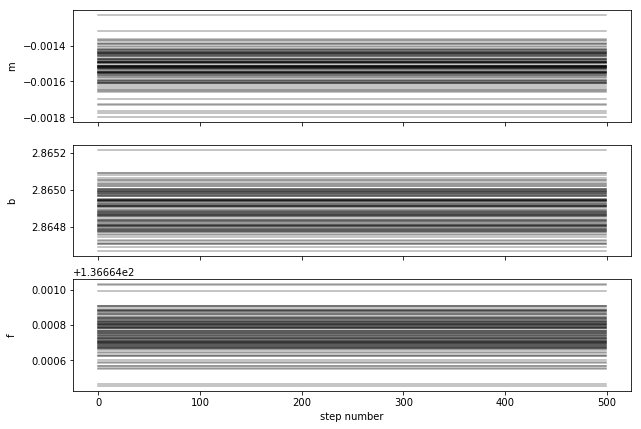

In [15]:
# plt.figure(1)
# fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
# samples = sampler.chain
# labels = ["m", "b"]
# for i in range(ndim):
#     ax = axes[i]
#     ax.plot(samples[:, :, i].T, "k", alpha=0.3)
#     ax.set_ylabel(labels[i])
#     ax.yaxis.set_label_coords(-0.1, 0.5)

# axes[-1].set_xlabel("step number");
# plt.show()

plt.figure(1)
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["m", "b", "f"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i].T, "k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.show()

In [16]:
flat_samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

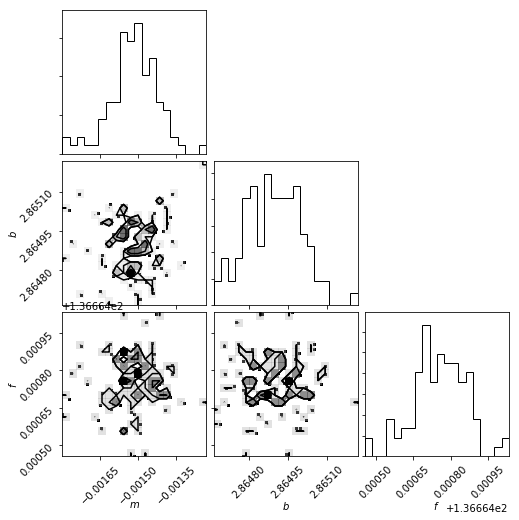

In [17]:
# plt.figure()
# fig = corner.corner(flat_samples, labels=["$m$", "$b$"],
#                       truths=[m_true, b_true])
# plt.show()

plt.figure()
fig = corner.corner(flat_samples, labels=["$m$", "$b$", "$f$"],
                      truths=[m_true, b_true, f_true])
plt.show()

In [18]:
from IPython.display import display, Math
results = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    results.append(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

9.10496297622e-05 0.304908732784


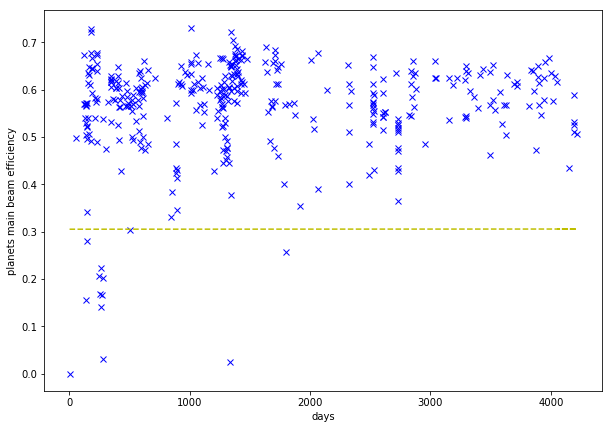

In [38]:
plt.figure(figsize=(10,7))
plt.plot(days, planets_etamb, 'bx')
m = results[0][1]
b = results[1][1]
print(m, b)
y = m*days/1000 + b
plt.xlabel('days')
plt.ylabel('planets main beam efficiency')
plt.plot(days, y, '--', color='y')
plt.show()